In [1]:
VERSION

v"1.8.1"

In [2]:
ENV["COLUMNS"] = 1000
ENV["LINES"] = 20;

In [3]:
# using Pkg
# module_name = "ScatteredInterpolation"
# Pkg.add(module_name)
# Pkg.update(module_name)
# Pkg.build(module_name)

In [5]:
using DataFrames
using GLMakie
using JLD2

using Revise
using Astroshaper
import SPICE

In [6]:
meta_kernel = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/mk/hera_study_PO_EMA_2024_shapeViewer.tm"

SPICE.furnsh(meta_kernel)

In [7]:
et_start = SPICE.utc2et("2027-02-09T22:00:00")
et_end   = SPICE.utc2et("2027-02-18T22:00:00")
step     = 3600/72

et_range = et_start:step:et_end

@show et_range
@show length(et_range);

et_range = 8.554824691849957e8:50.0:8.562600691849957e8
length(et_range) = 15553


In [8]:
# save_range = findall(et_range .> et_range[end] - 7.63262 * 3600)
save_range = 1:length(et_range)

@show save_range[begin]
@show save_range[end]
@show length(save_range);

save_range[begin] = 1
save_range[end] = 15553
length(save_range) = 15553


In [9]:
sun_d1 = spkpos("SUN",       et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS")
sun_d2 = spkpos("SUN",       et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d1_d2  = spkpos("DIDYMOS",   et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d2_d1  = spkpos("DIMORPHOS", et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS");

In [10]:
D1_TO_D2 = pxform("DIDYMOS_FIXED",   "DIMORPHOS_FIXED", et_range)
D2_TO_D1 = pxform("DIMORPHOS_FIXED", "DIDYMOS_FIXED",   et_range)

D1_TO_J2000 = pxform("DIDYMOS_FIXED",   "J2000", et_range)
D2_TO_J2000 = pxform("DIMORPHOS_FIXED", "J2000", et_range);

In [11]:
SPICE.kclear()

In [12]:
# fig = Figure()
# ax = Axis3(fig[1, 1], aspect=:data)

# scatter!([r[1] for r in sun_d1], [r[2] for r in sun_d1], [r[3] for r in sun_d1], color=:orange, size=2)

# display(fig)

# Shape Models: Didymos & Dimorphos

In [13]:
shapedir = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/dsk"

shapepath1 = joinpath(shapedir, "g_50677mm_rad_obj_dida_0000n00000_v001.obj")
shapepath2 = joinpath(shapedir, "g_06650mm_rad_obj_didb_0000n00000_v001.obj")

shape1 = ShapeModel(shapepath1; scale=1000, find_visible_facets=true, save_shape=false)
shape2 = ShapeModel(shapepath2; scale=1000, find_visible_facets=true, save_shape=false)
shapes = (shape1, shape2);

In [15]:
println(shapes[1])
println(shapes[2])

Shape model
-----------
Nodes             : 1000
Faces             : 1996
Surface area      : 1.9587914739775863e6
Volume            : 2.485481753075182e8
Equivalent radius : 390.03836143582186
Center-of-Figure  : [2.484674354494825e-6, -2.0997384259416257e-6, 2.190089591373722e-6]
Inertia tensor    : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]

Shape model
-----------
Nodes             : 1538
Faces             : 3072
Surface area      : 53920.63065752515
Volume            : 1.1314114665400542e6
Equivalent radius : 64.64138537338498
Center-of-Figure  : [2.009646200056278e-16, 3.5852088209004e-16, -2.9131831316015805e-15]
Inertia tensor    : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]



# TPM only on Didymos

In [14]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric  Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
)

Thermophysical parameters
-------------------------
A_B   : 0.059
A_TH  : 0.0
k     : 0.125
ρ     : 2170.0
Cp    : 600.0
ϵ     : 0.9
-------------------------
t_bgn : 8.554824691849957e8
t_bgn : 105180.37410616312 (Normalized by period P)
t_end : 8.555688691849957e8
t_end : 105190.99686542484 (Normalized by period P)
Nt    : 241
Δt    : 360.0000000001112
Δt    : 0.044261496923839634 (Normalized by period P)
-------------------------
z_max : 0.6
z_max : 6.057014348123621 (Normalized by skin depth l)
Nz    : 41
Δz    : 0.015
Δz    : 0.15142535870309054 (Normalized by skin depth l)
-------------------------
P     : 8133.4800000000005
l     : 0.09905870541414048
Γ     : 403.4228550788862
λ     : 0.15360983102923334
-------------------------


In [15]:
savepath = "tmp.jld2"
run_TPM!(shape1, et_range, sun_d1, thermo_params, savepath, save_range)

jldopen(savepath, "r+") do file
    file["D1_TO_J2000"] = D1_TO_J2000[save_range]
end;

0.004908200959444313
0.008440054943300192
0.0120891306916738
0.015479726455203796
0.018105898323619845
0.02022211117218463
0.022302482592344165
0.023993298923428767
0.02507001673936443
0.025161856581598495
0.025226459932493065
0.025655241399176316
0.025944991777380803
0.02606253710843004
0.02633656932021363
0.02676760435978366
0.02722850229552078
0.02850008826171463
0.03005313282160656
0.03149456711492343
0.03248836548624546
0.03330803859327788
0.035121587741316226
0.03789245204501958
0.04084543817002062
0.043727942454751756
0.046360235124897495
0.048515426278286054
0.051001378912751555
0.05395117596392233
0.05624509368856626
0.057264118605862765
0.0573989129080692
0.05802424120096614
0.05893229372801653
0.05937307391267671
0.059604641720430195
0.06064644114766941
0.061651409240015186
0.06327538097533522
0.06557746794431314
0.06732309138818
0.068426080099693
0.06806284647983474
0.06805704642932821
0.06982009055907691
0.07194319698751205
0.07429277548125007
0.07702046909489069
0.0791214

0.1615303114344711
0.1618332073052682
0.1638534280756038
0.16519827533751433
0.16532060898207523
0.1659315905338997
0.16878760262880313
0.1709034417779111
0.17454925455249937
0.17783888941576442
0.1790949047359582
0.17857916242269845
0.17520987778536692
0.17308622091052003
0.17346835905504723
0.17342250244681656
0.17387439545080127
0.17588586933160463
0.1771513582650249
0.1803249381879716
0.1866500130855967
0.19231868889755457
0.19511846298641067
0.19413134760618547
0.19513187257111084
0.19793403491466746
0.1985341427735009
0.1980991610300076
0.1997364753861443
0.20285070631444418
0.20530278452440534
0.2097641104318866
0.21255717263333046
0.2129222699711341
0.21029899049923356
0.2063732425606904
0.2050942986286046
0.20496774501404705
0.20432720765332843
0.20476092250017133
0.2062184528414495
0.20820172045489152
0.21293108873999214
0.21987387517680917
0.22475152605998097
0.2257592724567216
0.22542063911590066
0.2271910173087946
0.22906054598179107
0.22909724911136095
0.22920853741918423

0.2818386643883053
0.2844483689185169
0.284373978678143
0.2836570845798647
0.28622657194205847
0.28907047440757067
0.292523850183371
0.29766367443317815
0.3000270330385778
0.2994327107261004
0.29404991086271787
0.2890184876585402
0.2878633259684351
0.28637128635834597
0.2843833363240126
0.28435546723913585
0.28488679264114597
0.28696163114034423
0.29360371669622304
0.30183086342116405
0.3063159101826163
0.3057193335852628
0.305283426423836
0.3079957841827862
0.30898914360037816
0.30797516747858134
0.30820325260974785
0.3120500973806994
0.3142273422262713
0.3193260690964839
0.3234345313473845
0.3242344011624315
0.322332746596633
0.3158717666309642
0.31170512647303844
0.31097391581443395
0.3085243989532202
0.30663050908268163
0.30764064723076023
0.30773677459759097
0.311305750564581
0.32004539251541286
0.3275217480750224
0.3305975613503759
0.32783779900665466
0.3284238211093887
0.33178865413855363
0.3316370326483525
0.3299756087593143
0.3317496632591109


In [16]:
# draw(shape1; data=:temperature, colormap=:vik)

In [17]:
data = load("tmp.jld2");

In [18]:
# data["shape"]
# data["et_range"]
# data["sun"]
# data["thermo_params"]
# data["surf_temps"]
# data["forces"]
# data["torques"]

# data["D1_TO_J2000"]

# TPM only on Dimorphos

In [ ]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric  Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
);

In [ ]:
savepath = "tmp.jld2"
run_TPM!(shape2, et_range, sun_d2, thermo_params, savepath, save_range)

jldopen(savepath, "r+") do file
    file["D2_TO_J2000"] = D2_TO_J2000[save_range]
end;

In [ ]:
draw(shape2; data=:temperature, colormap=:vik)

# TPM on Binary Asteroid

In [17]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric  Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
);

In [18]:
savepath = "tmp.jld2"
run_TPM!(shapes, et_range, (sun_d1, sun_d2), D2_TO_D1, d2_d1, thermo_params, savepath, save_range)

# jldopen(savepath, "r+") do file
#     file["D2_TO_J2000"] = D2_TO_J2000[save_range]
# end;

In [21]:
# draw(shape1; data=:temperature, colormap=:vik)
# draw(shape2; data=:temperature, colormap=:vik)

In [22]:
data = load("tmp.jld2")
keys(data)

KeySet for a Dict{String, Any} with 8 entries. Keys:
  "et_range"
  "suns"
  "S2P"
  "thermo_params"
  "forces"
  "shapes"
  "surf_temps"
  "torques"

In [24]:
# data["shapes"]
# data["et_range"]
# data["suns"][1]
# data["thermo_params"]
# data["surf_temps"][1]
# data["forces"]
# data["torques"]

# data["D1_TO_J2000"]

# Temperature Map
- どれくらいの撮像間隔なら熱物性値を決められるか？

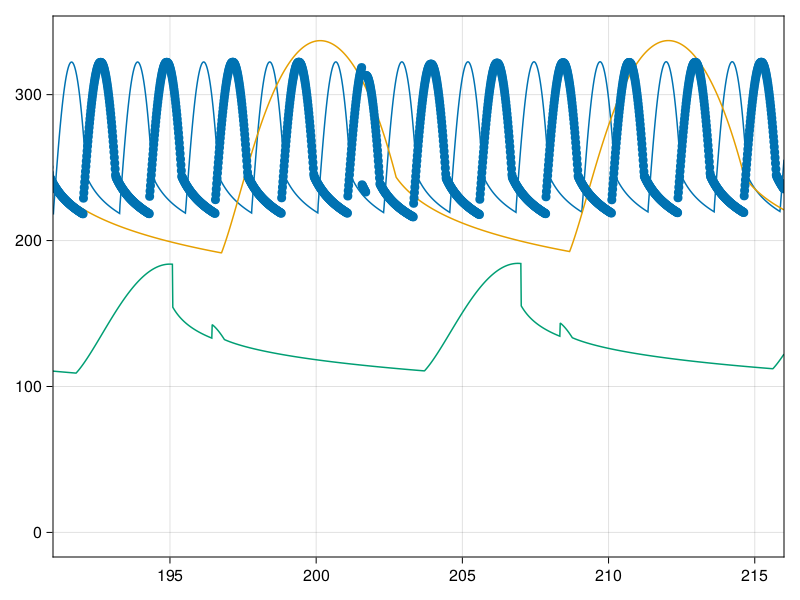

In [25]:
fig = Figure()
ax = Axis(fig[1, 1])

ts = @. (data["et_range"] - data["et_range"][begin]) / 3600

lines!(ts, data["surf_temps"][1][302, :])  # At equator
lines!(ts, data["surf_temps"][2][528, :])  # At equator

scatter!(ts, data["surf_temps"][1][600, :])
# lines!(ts, data["surf_temps"][2][1000, :])
lines!(ts, data["surf_temps"][2][3000, :])

xlims!(191, 216)
# xlims!(201, 203)
# ylims!(150, 350)

display(fig)

Max. temperature: 187.6695383092941
Min. temperature: 0.00020765066625250722


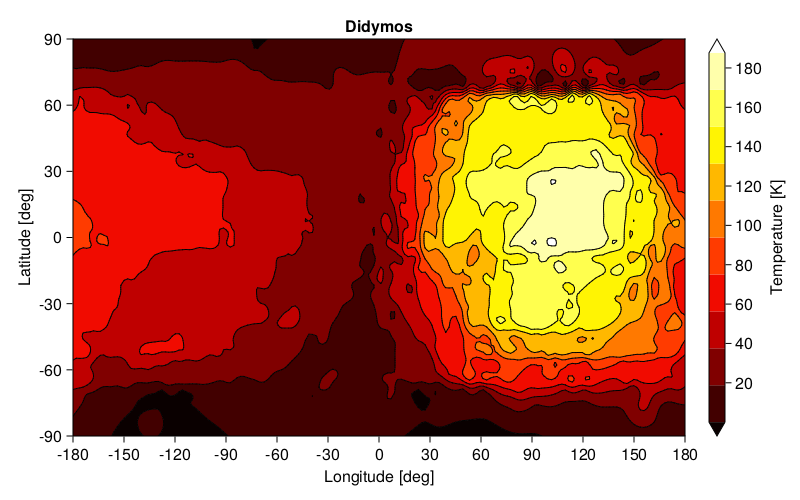

In [35]:
temps1 = data["surf_temps"][1][:, 114]
temperature_map(shape1, temps1; nlevels=10, title="Didymos", filepath="tmp/temp_map_Didymos.pdf")

Max. temperature: 253.6173037816231
Min. temperature: 0.0


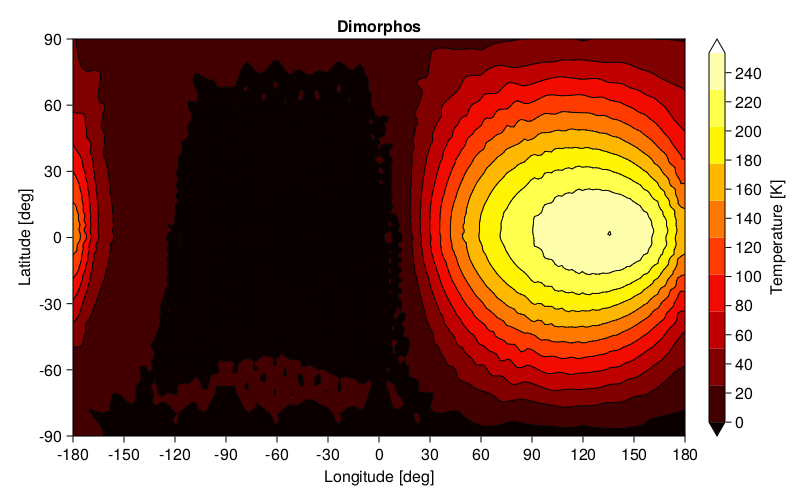

In [36]:
temps2 = data["surf_temps"][2][:, 114]
temperature_map(shape2, temps2; nlevels=10, title="Dimorphos", filepath="tmp/temp_map_Dimorphos.pdf")

Max. temperature: 253.6173037816231
Min. temperature: 0.0


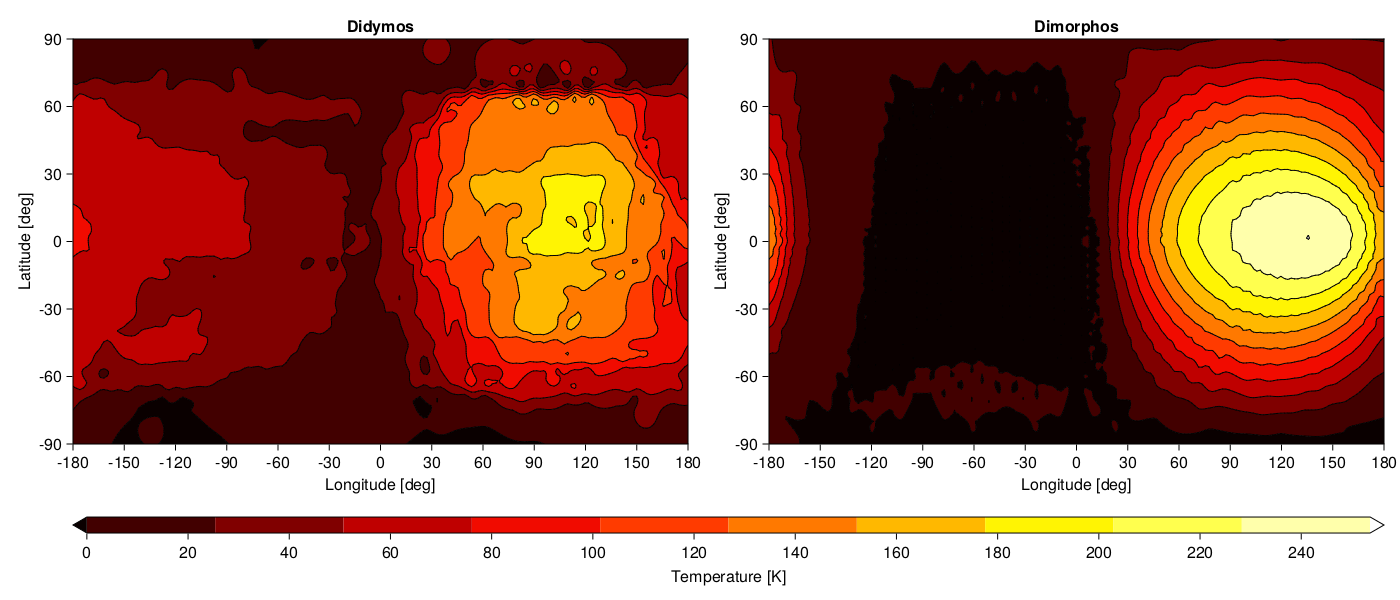

In [37]:
temperature_map(shapes..., temps1, temps2; nlevels=10, titles=("Didymos", "Dimorphos"), filepath="tmp/temp_maps.pdf")

In [40]:
# draw(shape1; data=temps1, colormap=:hot, strokewidth=0)
# draw(shape2; data=temps2, colormap=:hot, strokewidth=0)

In [42]:
meta_kernel = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/mk/hera_study_PO_EMA_2024_shapeViewer.tm"

SPICE.furnsh(meta_kernel)

In [44]:
# for (i, et) in enumerate(data["et_range"])
#     temps1 = data["surf_temps"][1][:, i]
#     temps2 = data["surf_temps"][2][:, i]
#     filepath = "./tmp/temp_maps/temp_maps_" * string(et) * ".png"
#     titles = (
#         "Didimos: "   * SPICE.et2utc(et, "C", 0),
#         "Dimorphos: " * SPICE.et2utc(et, "C", 0),
#     )
#     temperature_map(shape1, shape2, temps1, temps2; colorrange=(0,350), nlevels=10, filepath, titles)
# end

In [179]:
SPICE.kclear()